<a href="https://colab.research.google.com/github/abhitall/BayesNET/blob/main/BayesNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import required module
import json
import random
import numpy as np
import networkx as nx
from networkx.readwrite import json_graph
from networkx.algorithms.dag import ancestors
from matplotlib import pyplot as plt
from itertools import chain, combinations, tee


0 1  Conditional probability = 0.69 
0 2  Conditional probability = 0.61 
0 3  Conditional probability = 0.01 
0 4  Conditional probability = 0.94 
1 2  Conditional probability = 0.12 
1 3  Conditional probability = 0.61 
1 4  Conditional probability = 0.34 
2 3  Conditional probability = 0.79 
2 4  Conditional probability = 0.09 
3 4  Conditional probability = 0.27 
finding descendants of nodes
For node 0 It's descendants are [1, 2, 3, 4]
For node 1 It's descendants are [2, 3, 4]
For node 2 It's descendants are [3, 4]
For node 3 It's descendants are [4]


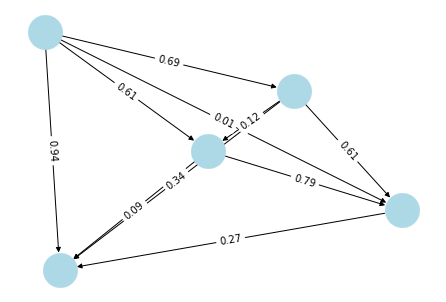

In [ ]:
# create object
#G = nx.barabasi_albert_graph(5, 2)
N = 5
seed = 20
G = nx.gnp_random_graph(5, 2, seed=5)
pos = nx.spring_layout(G, seed=seed)
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = random.random()
    print(u, v, " Conditional probability = %1.2f " % G.edges[u, v]['weight'])
# note that these weights are only there for demonstration purposes. In your code
# you will need to replace the weights by probability tables for each node.
# illustrate graph
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
labels = {e: round(G.edges[e]['weight'], 2) for e in G.edges}
nx.draw(G, node_size=1200, node_color='lightblue', linewidths=0.25,
        font_size=10, font_weight='bold', pos=pos, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# finding descendants of a node
print("finding descendants of nodes")
desc = [[] for _ in range(N)]
for link in G.edges():
    desc[link[0]].append(link[1])
for node in range(N-1):
    print("For node", node, "It's descendants are", desc[node])


In [ ]:
def powerset(iterable):
    # powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    s = list(iterable)
    len_powerset = 0
    powerset_vals = chain.from_iterable(
        combinations(s, r) for r in range(len(s)+1))
    return powerset_vals


def clean_json_adj_load(file_name):
    with open(file_name) as d:
        json_data = json.load(d)
    H = json_graph.adjacency_graph(json_data)
    for edge_here in H.edges():
        del(H[edge_here[0]][edge_here[1]]["id"])
    return H


def clean_json_adj_loads(json_str):
    json_data = json.loads(json_str)
    H = json_graph.adjacency_graph(json_data)
    for edge_here in H.edges():
        del(H[edge_here[0]][edge_here[1]]["id"])
    return H


def intervention_effects(graph):
    def f(x): return x[0].endswith("int")
    return [x for x in graph.edges() if f(x)]


def cause_observation_pairings(graph):
    def f(x): return x[0].endswith("★") and x[1].endswith("out")
    return [x for x in graph.edges() if f(x)]


def hidden_cause_pairs(graph):
    def f(x): return x[0].endswith("★") and x[1].endswith("★")
    return [x for x in graph.edges() if f(x)]


def completeDiGraph(nodes):
    """
    Args:
        modes: nodes are a list of strings that specify the node names

    Returns:
        returns directed graph with all possible edges for a set of nodes
    """
    G = nx.DiGraph()  # Creates new graph
    G.add_nodes_from(nodes)  # adds nodes to graph
    edgelist = list(combinations(nodes, 2))  # build list of directed edges
    # add symmetric edges
    edgelist.extend([(y, x) for x, y in list(combinations(nodes, 2))])
    edgelist.extend([(x, x) for x in nodes])  # add self-loops
    G.add_edges_from(edgelist)  # add edges to graph
    return G


def filter_Graph(G, filter_set):
    """
    Args:
        G: graph on which operations are to be made
        filter_set: applies a set of filters encoded as closures/first-order functions.

    Returns:
        return a graph as output.
    """
    graph = G.copy()
    for f in filter_set:
        graph = f(graph)
    return graph


def partialConditionalSubgraphs(G, edge_set, condition_list):
    """
    Args: 
        G: graph from which subgraphs will be taken.
        edge_set: sets of edges
        condition_list: list of first order functions that will be applied to filter the subgraphs of G.
        Functions in condition_list should return a single boolean value for every graph passed into them.

    Returns:
        a graph generator/iterator such that any conditions specified in condition_list 
        are met by some subgraph of G.
    """
    try:
        condition_list[0]
    except TypeError:
        raise TypeError("""Subsampling from a graph requires the inclusion of a set of conditions encoded as first-class functions that accept networkX graphs as input and return boolean values.""")
    edge_powerset = powerset(edge_set)

    for edges in powerset(edge_set):
        G_test = G.copy()
        G_test.remove_edges_from(edges)
        if all([c(G_test) for c in condition_list]):
            yield G_test


def conditionalSubgraphs(G, condition_list):
    """
    Args: 
        G: graph from which subgraphs will be taken.
        condition_list: list of first order functions that will be applied to filter the subgraphs of G.
        Functions in condition_list should return a single boolean value for every graph passed into them.

    Returns:
        a graph generator/iterator such that any conditions specified in condition_list 
        are met by some subgraph of G.
        This is intended to be used in conjunction with completeDiGraph or any graph which subgraphs 
        are expected to be taken.
    """
    try:
        condition_list[0]
    except TypeError:
        raise TypeError("""
        Subsampling from a graph requires passing in a list of conditions encoded
        as first-class functions that accept networkX graphs as an input and return boolean values.""")
    # edge_powerset = powerset(G.edges())

    for edges in powerset(G.edges()):
        G_test = G.copy()
        G_test.remove_edges_from(edges)
        if all([c(G_test) for c in condition_list]):

            yield G_test


def create_path_complete_condition(transmit_node_pairs):
    """
    This creates a closure that takes a graph as its input and returns a boolean value indicating whether the pairs of nodes in transmit_node_pairs are able to communicate from each tuple in transmit_node_pairs such that there is a path from transmit_node_pairs[i][0] to transmit_node_pairs[i][1]
    """
    def path_complete_condition(G):
        return all([nx.has_path(G, x, y) for x, y in transmit_node_pairs])
    return path_complete_condition


def create_no_input_node_condition(node_list):
    """
    This creates a closure that takes a graph as its input and returns a boolean value indicating whether there is an input node 
    """
    def no_input_node_condition(G):
        return all([G.in_degree(y) == 0 for y in node_list])
    return no_input_node_condition


def create_is_dag_condition(node_list):
    """
    This creates a closure that takes a graph as its input and returns a boolean value indicating whether its a DAG or not
    """
    def is_dag_condition(G):
        return nx.is_directed_acyclic_graph(G)
    return is_dag_condition


def create_no_self_loop_condition():
    """
    This creates a closure that takes a graph as its input and returns a boolean value indicating whether there is a self or not
    """
    def no_self_loop_condition(G):
        return not(any([(y, y) in G.edges() for y in list(G.nodes())]))
    return no_self_loop_filter


def create_explicit_parent_condition(parentage_tuple_list):
    """
    This states for a child node, what its explicit parents are.
    """
    def explicit_parent_condition(G):
        return all(
            [sorted(G.in_edges(y[0])) == sorted([(x, y[0]) for x in y[1]])
             for y in parentage_tuple_list])
    return explicit_parent_condition


def create_explicit_child_condition(parentage_tuple_list):
    """ 
    This states for a parent node, what its explicit children are.
    """
    def explicit_child_condition(G):
        return all(
            [sorted(G.out_edges(y[0])) == sorted([(y[0], x) for x in y[1]])
             for y in parentage_tuple_list])
    return explicit_child_condition


def create_no_direct_arrows_condition(node_pair_list):
    """
    This creates a closure that takes a graph as its input and returns a boolean value indicating whether there are no directed arrows
    """
    def no_direct_arrows_condition(G):
        return not(any([y in G.edges() for y in node_pair_list]))
    return no_direct_arrows_condition


def create_no_output_node_condition(node_list):
    """
    This creates a closure that takes a graph as its input and returns a boolean value indicating whether there is an output node or not
    """
    def no_output_node_condition(G):
        return all([G.out_degree(y) == 0 for y in node_list])
    return no_output_node_condition


def extract_remove_self_loops_filter():
    """
    used to remove self loop filters
    """
    def remove_self_loops_filter(G):
        graph = G.copy()
        # this is a networkX method that allows you to automatically grab edges that are self-loops.
        graph.remove_edges_from(graph.selfloop_edges())
        return graph
    return remove_self_loops_filter


def extract_remove_inward_edges_filter(exceptions_from_removal):
    """
    This covers both orphans and explicit_child_parentage.
    """
    def remove_inward_edges_filter(G):
        graph = G.copy()
        list_of_children = [x[0]
                            for x in exceptions_from_removal if len(x[1]) > 0]
        list_of_orphans = [x[0]
                           for x in exceptions_from_removal if len(x[1]) == 0]

        for orphan in list_of_orphans:
            graph.remove_edges_from(
                [edge for edge in graph.edges() if edge[1] == orphan])

        for child in list_of_children:
            current_edges = graph.in_edges(child)
            valid_edges = [
                (y, x[0]) for x in exceptions_from_removal if x[0] == child for y in x[1]]
            graph.remove_edges_from(
                [edge for edge in current_edges if edge not in valid_edges])

        return graph
    return remove_inward_edges_filter


def extract_remove_outward_edges_filter(exceptions_from_removal):
    """
    This creates a closure that goes through the list of tuples to explicitly state which edges are leaving from the first argument of each tuple.
    Each tuple that is passed in has two members. The first member is a string representing a single node from which the children will be explicitly stated. The second member is the list of nodes that are in its child set.
    IThis covers both barren_nodes and explicit_parent_offspring.
    """
    def remove_outward_edges_filter(G):
        graph = G.copy()
        list_of_parents = [x[0]
                           for x in exceptions_from_removal if len(x[1]) > 0]
        list_of_barrens = [x[0]
                           for x in exceptions_from_removal if len(x[1]) == 0]

        for barren in list_of_barrens:
            graph.remove_edges_from(
                [edge for edge in graph.edges() if edge[0] == barren])

        for parent in list_of_parents:
            current_edges = graph.out_edges(parent)
            valid_edges = [
                (x[0], y) for x in exceptions_from_removal if x[0] == parent for y in x[1]]
            graph.remove_edges_from(
                [edge for edge in current_edges if edge not in valid_edges])

        return graph
    return remove_outward_edges_filter


def barren_nodes_filter(list_of_barren_nodes):
    """
    This allows for a nicer syntax for specifying that nodes are barren (that they have no children).
    """
    new_list = [(node, []) for node in list_of_barren_nodes]
    return extract_remove_outward_edges_filter(new_list)


def orphan_nodes_filter(list_of_orphan_nodes):
    """
    This allows for a nicer syntax for specifying that nodes are orphans (that they have no parents).

    """
    new_list = [(node, []) for node in list_of_orphan_nodes]
    return extract_remove_inward_edges_filter(new_list)


def new_conditional_graph_set(graph_set, condition_list):
    """
    This returns a copy of the old graph_set and a new graph generator which has 
    the conditions in condition_list applied to it.

    Warning: This function will devour the iterator that you include as the graph_set input, 
    you need to redeclare the variable as one of the return values of the function.

    Thus a correct use would be:
    a,b = new_conditional_graph_set(a,c)

    The following would not be a correct use:
    x,y = new_conditional_graph_set(a,c)

    Args: 
    graph_set is a graph-set generator
    condition_list is a list of first order functions returning boolean values when passed a graph.
    """
    try:
        condition_list[0]
    except TypeError:
        raise TypeError("""
        Subsampling from a graph requires passing in a list of conditions encoded
        as first-class functions that accept networkX graphs as an input and return boolean values.""")
    graph_set_newer, graph_set_test = tee(graph_set, 2)

    def gen():
        for G in graph_set_test:
            G_test = G.copy()
            if all([c(G_test) for c in condition_list]):
                yield G_test
    return graph_set_newer, gen()


def completeDiGraph(nodes):
    """
    Args:
        nodes are a list of strings that specify the node names

    Returns:
        returns a directed graph with all possible edges
    """
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    edgelist = list(combinations(nodes, 2))
    edgelist.extend([(y, x) for x, y in edgelist])
    edgelist.extend([(x, x) for x in nodes])
    G.add_edges_from(edgelist)
    return G


def conditionalSubgraphs(G, condition_list):
    """
    Args: 
        G is a graph from which subgraphs will be taken.
        condition_list is a list of first order functions that define conditions subgraphs of G need to meet to be output.
        Functions in condition_list should return a single boolean value for every graph passed into them.

    Returns:
        returns a graph generator/iterator such that any conditions specified in condition_list 
        are met by some subgraph of G.
        This is intended to be used in conjunction with completeDiGraph or any graph which subgraphs 
        are expected to be taken.
    """
    try:
        condition_list[0]
    except TypeError:
        raise TypeError("""
        Subsampling from a graph requires passing in a list of conditions encoded
        as first-class functions that accept networkX graphs as an input and return boolean values.""")

    for edges in powerset(G.edges()):
        G_test = G.copy()
        G_test.remove_edges_from(edges)
        if all([c(G_test) for c in condition_list]):
            yield G_test


def create_no_self_loops_condition():
    """
    This factory allows us to specify that there are no valid self-loops
    This returns a function that takes an graph argument (G). 

    NB: This is a common assumption of causal graphs, because they are not considered to be extended through time.
    """

    def no_self_loops_condition(G):
        return not(any([(y, y) in G.edges() for y in list(G.nodes())]))
    return no_self_loops_condition


def create_path_complete_condition(transmit_node_pairs):
    """
    This factory allows us to specify that there are valid directed paths between pairs of nodes.
    This returns a function that takes an graph argument (G) 
    and verifies that for the list of node pairs the graph meets those dependency conditions. 

    NB: This is useful for making known indirect dependencies explicit.

    Args:
        node_list is a list of 2-tuples of nodes that will have valid direct paths 
        from the first of the nodes to the second.
    """

    def path_complete_condition(G):
        return all([nx.has_path(G, x, y) for x, y in transmit_node_pairs])
    return path_complete_condition


def create_no_input_node_condition(node_list):
    """
    This factory allows us to specify that no directed can be directed into a set of nodes.
    This returns a function that takes an graph argument (G) and verifies that 
    none of the nodes in node_list are child nodes. 

    NB: This is useful for making interventions explicit over a set of graphs.

    Args:
        node_list is a list of nodes that will have no parents
    """

    def no_input_node_condition(G):
        return all([G.in_degree(y) == 0 for y in node_list])
    return no_input_node_condition


def new_conditional_graph_set(graph_set, condition_list):
    """
    This returns a copy of the old graph_set and a new graph generator which has 
    the conditions in condition_list applied to it.

    Warning: This function will devour the iterator that you include as the graph_set input, 
    you need to redeclare the variable as one of the return values of the function.

    Thus a correct use would be:    
    a,b = new_conditional_graph_set(a,c)

    The following would not be a correct use:
    x,y = new_conditional_graph_set(a,c)

    Args: 
        graph_set is a graph-set generator
        condition_list is a list of first order functions returning boolean values when passed a graph.
    """

    try:
        condition_list[0]
    except TypeError:
        raise TypeError("""
        Subsampling from a graph requires passing in a list of conditions encoded
        as first-class functions that accept networkX graphs as an input and return boolean values.""")
    graph_set_newer, graph_set_test = tee(graph_set, 2)

    def gen():
        for G in graph_set_test:
            G_test = G.copy()
            if all([c(G_test) for c in condition_list]):
                yield G_test
    return graph_set_newer, gen()


def extract_remove_self_loops():
    def remove_self_loops(G):
        graph = G.copy()
        graph.remove_edges_from(nx.selfloop_edges(graph, data=True))
        return graph
    return remove_self_loops


def filter_Graph(G, filter_set):
    graph = G.copy()
    for f in filter_set:
        graph = f(graph)
    return graph


def sample_from_graph(G, func_dictionary=None, k=1):
    """
    This is the function that samples from the rich networkX Bayes Net graph using the parameterization specified in the node attributes.

    Args:
        G is the graph being sampled from.
        k is the number of samples.
    """
    if func_dictionary == None:
        func_dictionary = {"choice": np.random.choice}

    nodes_dict = list(G.nodes(data=True))
    node_ids = np.array(list(G.nodes()))
    state_spaces = [(node[0], node[1]["state_space"]) for node in nodes_dict]
    orphans = [node for node in nodes_dict if node[1]["parents"] == []]
    sample_values = np.empty([len(state_spaces), k], dtype='U20')
    sampled_nodes = []

    for node in orphans:
        # sample k values for all orphan nodes
        samp_func = string_to_sample_function(
            node[1]["sample_function"], func_dictionary)
        samp_states = node[1]["state_space"]
        samp_distribution = node[1]["distribution"]
        samp_index = list(G.nodes()).index(node[0])
        sample_values[samp_index, :] = samp_func(
            samp_states, size=[1, k], p=samp_distribution)
        sampled_nodes.append(node[0])

    while set(sampled_nodes) < set(list(G.nodes())):
        nodes_to_sample = check_if_parents_filled(G, sampled_nodes)
        # nodes_to_sample returns a list of node names that need to be sampled

        for n in nodes_to_sample:
            # extracts the indices of the parents of the node to be sampled and their values
            parent_indices = [(parent, list(G.nodes()).index(parent))
                              for parent in G.nodes[n]["parents"]]
            parent_vals = [(parent[0], sample_values[parent[1], :])
                           for parent in parent_indices]

            # extracts sample index
            samp_index = list(G.nodes()).index(n)
            sample_values[samp_index, :] = conditional_sampling(
                G, n, parent_vals, func_dictionary, k)
            sampled_nodes.append(n)

    return {node: sample_values[list(G.nodes()).index(node)] for node in sampled_nodes}


def check_if_parents_filled(G, sampled_nodes):
    """
    This function will return those nodes who have not yet been sampled, whose parents have been sampled.
    Args:
        G is a networkX graph
        sampled_nodes are a list of node names
    """
    check_nodes = [x for x in list(G.nodes()) if x not in sampled_nodes]
    nodes_to_be_sampled = []
    for node in G.nodes(data=True):
        if (node[0] in check_nodes) & (node[1]["parents"] <= sampled_nodes):
            nodes_to_be_sampled.append(node[0])

    if len(nodes_to_be_sampled) == 0:
        raise RuntimeError(
            "You should never be running this when no values are returned")
    return nodes_to_be_sampled


def nodeset_query(G, node_set, attrib=[]):
    """
    This is a helper function for querying particular attributes from a node  
    Args:
        G is a networkX style graph
        node_set is a list of node names that are in G
        attrib are a list of attributes associated with the nodes in G
    """
    if len(attrib) == 0:
        return [node for node in G.nodes(data=True) if node[0] in node_set]
    else:
        return_val = []
        for node in G.nodes(data=True):
            if node[0] in node_set:
                return_val.append(
                    (node[0], {attr: node[1][attr] for attr in attrib}))
        return return_val


def conditional_sampling(G, node, parent_vals, func_dictionary, k=1):
    """
    This function takes a graph as input, a node to sample from in that graph and a set of values for the parents of that node.
    This function should not be consulted for Args without any parents.
    Args: 
        G is a networkX style graph
        node is a node in G
        parent_vals are the values of the parents of node realized k times
        returns an array of values 
    """

    try:
        node in G
    except KeyError:
        print("{} is not in graph".format(n))

    output = np.empty(k, dtype="U20")
    for i in np.arange(k):
        par_val_list = []
        for parent in parent_vals:
            par_val_list.append(tuple([parent[0], parent[1][i]]))
        samp_distribution = G.nodes[node]["distribution"][tuple(par_val_list)]

        samp_func = string_to_sample_function(
            G.nodes[node]["sample_function"], func_dictionary)
        samp_states = G.nodes[node]["state_space"]
        temp_output = samp_func(samp_states, size=1, p=samp_distribution)
        output[i] = temp_output[0]
    return output


def string_to_sample_function(func_name, func_dictionary=None):
    """
    This allows the function to be passed in as a string that is mapped to a first-class function to other methods.
    sample_function is a string that maps onto a function in the dictionary defined below.
    This takes two arguments a func_dictionary 
    """
    if func_dictionary == None:
        func_dictionary = {"choice": np.random.choice}

    try:
        func_dictionary[func_name]
    except KeyError:
        print(
            "{} is not a function defined in the dictionary you passed.".format(func_name))

    return func_dictionary[func_name]


def print_prob_est(test):
    for key, value in test.items():
        for unique_element in set(value):
            prob_est = sum(sum([value == unique_element]))/len(value)
            print("p̂({}={}) = {} ± {:.2e}".format(
                key, unique_element, prob_est, np.sqrt(prob_est/len(value))))
        print("\n")


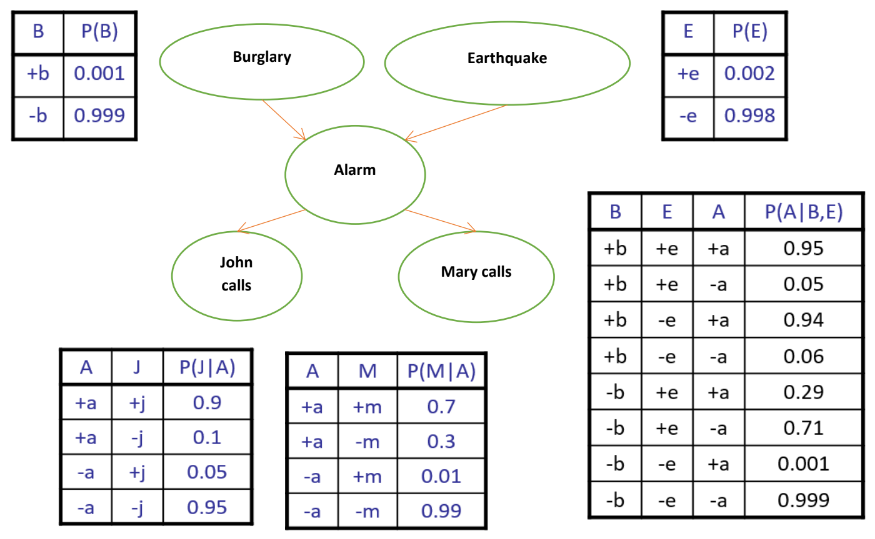

In [ ]:
nodes = ["a", "b", "c", "d"]
known_ancestral_relations = [("a", "b"), ("a", "c"), ("a", "d")]
orphan_nodes = ["a"]


In [ ]:
G = completeDiGraph(nodes)

c1 = create_path_complete_condition(known_ancestral_relations)
c2 = create_no_input_node_condition(orphan_nodes)
c3 = create_no_self_loops_condition()

graph_set = conditionalSubgraphs(G, [c1, c2, c3])

len(list(graph_set))


304

In [ ]:
# Use filters! They speed up the process.

G = completeDiGraph(nodes)

f1 = extract_remove_self_loops()
G_filtered = filter_Graph(G, [f1])

c1 = create_path_complete_condition(known_ancestral_relations)
c2 = create_no_input_node_condition(orphan_nodes)
graph_set = conditionalSubgraphs(G_filtered, [c1, c2])

len(list(graph_set))


304

In [ ]:
node_prop_list = [

    ("burglary", {
        "state_space": ("yes", "no"),
        "sample_function": "choice",
        "parents": [],
        "distribution": [.001, .999]
    }),

    ("earthquake", {
        "state_space": ("yes", "no"),
        "sample_function": "choice",
        "parents": [],
        "distribution": [.002, .998]
    }),

    ("alarm", {
        "state_space": ("on", "off"),
        "sample_function": "choice",
        "parents": ["burglary", "earthquake"],
        "distribution":{
            (("burglary", "yes"), ("earthquake", "yes")): [.95, .05],
            (("burglary", "yes"), ("earthquake", "no")): [.94, .06],
            (("burglary", "no"), ("earthquake", "yes")): [.29, .71],
            (("burglary", "no"), ("earthquake", "no")): [0.001, 0.999]}
    }),

    ("john_calls", {
        "state_space": ("yes", "no"),
        "sample_function": "choice",
        "parents": ["alarm"],
        "distribution":{
            (("alarm", "on"),): [.9, .1],
            (("alarm", "off"),): [.05, .95]}
    }),

    ("mary_calls", {
        "state_space": ("yes", "no"),
        "sample_function": "choice",
        "parents": ["alarm"],
        "distribution":{
            (("alarm", "on"),): [.7, .3],
            (("alarm", "off"),): [.01, .99]}
    })

]


In [ ]:
dist_dict = {"choice": np.random.choice}

edge_list = [
    ("burglary", "alarm"),
    ("earthquake", "alarm"),
    ("alarm", "john_calls"),
    ("alarm", "mary_calls")
]


In [ ]:
func_dictionary = dist_dict
k = 10  # number of samples

G = nx.DiGraph()
G.clear()
G.add_edges_from(edge_list)
G.add_nodes_from(node_prop_list)
bn_sample = sample_from_graph(G, func_dictionary, k)


for key, value in bn_sample.items():
    print(str(key) + ": " + str(value), "\n")


burglary: ['no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no'] 

earthquake: ['no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no'] 

alarm: ['off' 'off' 'off' 'off' 'off' 'off' 'off' 'off' 'off' 'off'] 

john_calls: ['no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'no'] 

mary_calls: ['no' 'no' 'yes' 'no' 'no' 'no' 'no' 'no' 'no' 'no'] 



In [ ]:
print_prob_est(bn_sample)


p̂(burglary=no) = 1.0 ± 3.16e-01


p̂(earthquake=no) = 1.0 ± 3.16e-01


p̂(alarm=off) = 1.0 ± 3.16e-01


p̂(john_calls=yes) = 0.1 ± 1.00e-01
p̂(john_calls=no) = 0.9 ± 3.00e-01


p̂(mary_calls=yes) = 0.1 ± 1.00e-01
p̂(mary_calls=no) = 0.9 ± 3.00e-01




In [ ]:
class BayesNet():
    def conditional_probability(self, node, given):
        """method for predicting conditional probability"""
        for i in condition[node]:
            j = i.copy()
            j.pop(-1)
            if '|' in j:
                j.pop('|')
            if all(x in given for x in j):
                return i[-1]
            else:
                return 0

    def traverse(self, node, problem, visited, probability):
        """method for traversing graph"""
        if node in visited:
            return probability, visited
        else:
            probability *= self.conditional_probability(node, problem)
            visited.append(node)
            if problem[1] == '|':
                return probability, visited
            else:
                next = desc[node]
                if next:
                    for node in next:
                        probability, visited = self.traverse(node, problem, visited, probability)
        return probability, visited

    def predict(self, compute_list):
        """method for predicting probability"""
        visited = []
        probability = 1
        for node in compute_list:
            if node != '|':
                probability, visited = self.traverse(
                    node[0], compute_list, visited, probability)
            else:
                break
        return probability


def table(n):
    if n < 1:
        return [[]]
    table_1 = table(n-1)
    return [r + [c] for r in table_1 for c in ['+', '-']]


bayesnet = BayesNet()


### **Task 1**

0 : {1, 2}
0 : 8,4
1 : {2}
1 : 4,3
2 : set()
2 : 2,2
3 : {1, 2, 4}
3 : 16,5
4 : set()
4 : 2,2
finding descendants of nodes
For node 0 It's descendants are []
For node 1 It's descendants are [0, 3]
For node 2 It's descendants are [1]
For node 3 It's descendants are []
Conditional probability table of Node 1:

[(2, '+'), (1, '+'), 0.732]
[(2, '+'), (1, '-'), 0.268]
[(2, '-'), (1, '+'), 0.4335]
[(2, '-'), (1, '-'), 0.5665]


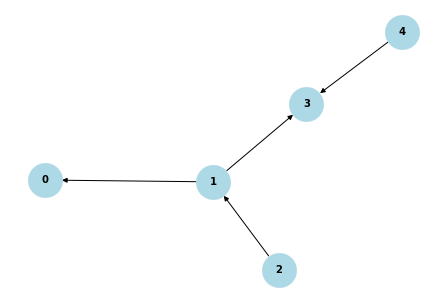

In [ ]:
G = nx.gnp_random_graph(5, 0.4, 558, directed=True)
while not nx.is_directed_acyclic_graph(G):
    G = nx.gnp_random_graph(5, 0.4, 558, directed=True)

N = 5
random.seed(100)
condition = {}

for i in G.nodes:
    print(f'{i} : {ancestors(G, i)}')
    print(f'{i} : {(2**(len(ancestors(G, i)) + 1))},{len(ancestors(G,i)) + 2}')

for i in G.nodes:
    list1 = [[]]
    for j in ancestors(G, i):
        list1[0].append(j)
    list1[0].append(i)
    list2 = table(len(ancestors(G, i))+1)
    condition[i] = [[(list1[0][l], list2[k][l])
                     for l in range(0, len(list1[0]))] for k in range(len(list2))]
    for m in range(0, len(condition[i]), 2):
        probability = round(random.random(), 4)
        condition[i][m].append(probability)
        condition[i][m+1].append(1-probability)

pos = nx.nx_pydot.graphviz_layout(G)
nx.draw(G, node_size=1200, node_color='lightblue', linewidths=0.25,
        font_size=10, font_weight='bold', pos=pos, with_labels=True)
print("finding descendants of nodes")
desc = [[] for _ in range(N)]
for link in G.edges():
    desc[link[0]].append(link[1])
for node in range(N-1):
    print("For node", node, "It's descendants are", desc[node])

print("Conditional probability table of Node 1:\n")
for i in range(len(condition[1])):
    print(condition[1][i])


### **Task 2**

In [ ]:
for i in G.nodes:
    print(f"Probability table for Node {i}:")
    for j in condition[i]:
        print(j)

compute_list_1 = [(0, '+'), (1, '+'), (2, '+'), (3, '+'), (4, '+')]
bayesnet.predict(compute_list_1)


Probability table for Node 0:
[(1, '+'), (2, '+'), (0, '+'), 0.1457]
[(1, '+'), (2, '+'), (0, '-'), 0.8543000000000001]
[(1, '+'), (2, '-'), (0, '+'), 0.4549]
[(1, '+'), (2, '-'), (0, '-'), 0.5450999999999999]
[(1, '-'), (2, '+'), (0, '+'), 0.7708]
[(1, '-'), (2, '+'), (0, '-'), 0.22919999999999996]
[(1, '-'), (2, '-'), (0, '+'), 0.7055]
[(1, '-'), (2, '-'), (0, '-'), 0.2945]
Probability table for Node 1:
[(2, '+'), (1, '+'), 0.732]
[(2, '+'), (1, '-'), 0.268]
[(2, '-'), (1, '+'), 0.4335]
[(2, '-'), (1, '-'), 0.5665]
Probability table for Node 2:
[(2, '+'), 0.8]
[(2, '-'), 0.19999999999999996]
Probability table for Node 3:
[(1, '+'), (2, '+'), (4, '+'), (3, '+'), 0.5329]
[(1, '+'), (2, '+'), (4, '+'), (3, '-'), 0.46709999999999996]
[(1, '+'), (2, '+'), (4, '-'), (3, '+'), 0.0802]
[(1, '+'), (2, '+'), (4, '-'), (3, '-'), 0.9198]
[(1, '+'), (2, '-'), (4, '+'), (3, '+'), 0.4559]
[(1, '+'), (2, '-'), (4, '+'), (3, '-'), 0.5441]
[(1, '+'), (2, '-'), (4, '-'), (3, '+'), 0.0479]
[(1, '+'), (2

0.03491946329702401

### **Task 3**

In [ ]:
compute_list_2 = [(4, '+'), '|', (0, '+'), (1, '+'), (2, '+'), (3, '+')]
bayesnet.predict(compute_list_2)


0.768

### **Task 4**

average connectivity:0, probability:0.732
average connectivity:0.5, probability:0.4335
average connectivity:1.0, probability:0.8
average connectivity:1.5, probability:0.768
average connectivity:2.0, probability:0.768
average connectivity:2.5, probability:0.768
average connectivity:3.0, probability:0.9561


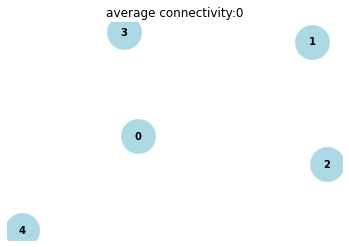

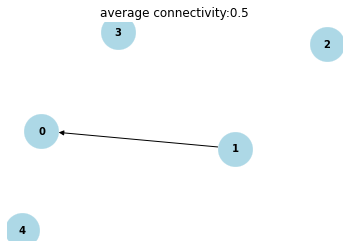

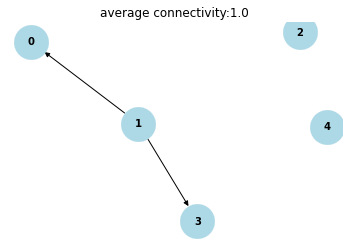

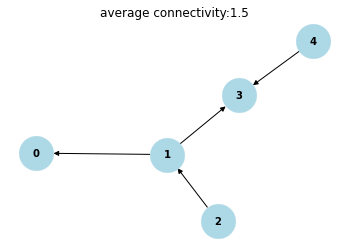

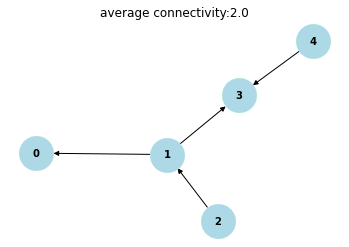

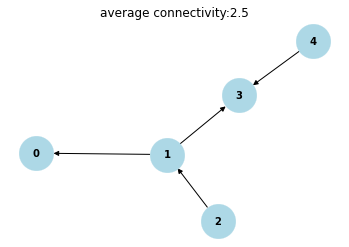

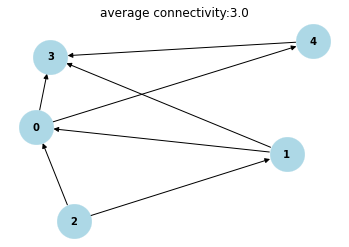

In [ ]:
avg = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for val in range(len(avg)):
    G = nx.gnp_random_graph(5, avg[val], 558, directed=True)
    while not nx.is_directed_acyclic_graph(G):
        G = nx.gnp_random_graph(5, avg[val], 558, directed=True)
    N = 5
    random.seed(100)
    condition = {}
    for i in G.nodes:
        list1 = [[]]
        for j in ancestors(G, i):
            list1[0].append(j)
        list1[0].append(i)
        list2 = table(len(ancestors(G, i))+1)
        condition[i] = [[(list1[0][l], list2[k][l]) for l in range(
            0, len(list1[0]))] for k in range(len(list2))]
        for m in range(0, len(condition[i]), 2):
            probability = round(random.random(), 4)
            condition[i][m].append(probability)
            condition[i][m+1].append(1-probability)
    desc = [[] for _ in range(N)]
    for link in G.edges():
        desc[link[0]].append(link[1])
    plt.figure(val)
    plt.title(f"average connectivity:{avg[val]*5}")
    pos = nx.nx_pydot.graphviz_layout(G)
    nx.draw(G, node_size=1200, node_color='lightblue', linewidths=0.25,
            font_size=10, font_weight='bold', pos=pos, with_labels=True)
    compute_list_2 = [(4, '+'), '|', (0, '+'), (1, '+'), (2, '+'), (3, '+')]
    result = bayesnet.predict(compute_list_2)
    print(f"average connectivity:{avg[val]*5}, probability:{result}")

plt.show()
